In [1]:
# utility 
import pandas as pd 
import numpy as np 
import torch 
import json
from modules.json_reader import get_df
from modules.json_reader import metadata_loader

# baseline model with scikit learn 
from sklearn.neural_network import MLPClassifier

###  Step 1: Download the file from Amazon and place it into data

- Run get_df(<path goes here>) afterwards to load json.gz as pandas dataframe


We can run our EDAs here. I believe some visuals with regards to data distribution and inconsistency should be outlined here and discussed in our final paper. And of course, we will need to address those issues before we train our model

### EDA

In [4]:
metadata = metadata_loader("data/meta_All_Beauty.json.gz")
metadata.head(1)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]


In [6]:
# here i have selected images 
df = get_df('data/All_Beauty_5.json.gz')

# Checking the na of each column. If there are NAs we can use imputers from scikit learn 
print("-"*6)
print(df.isna().sum())
print("-"*6)

# Checking variable types 
df.dtypes

------
overall              0
verified             0
reviewTime           0
reviewerID           0
asin                 0
style              645
reviewerName         0
reviewText           5
summary              5
unixReviewTime       0
vote              4717
image             5171
dtype: int64
------


overall           float64
verified             bool
reviewTime         object
reviewerID         object
asin               object
style              object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
vote               object
image              object
dtype: object

Review data and product metadata can be joined 

In [16]:
merged_df = pd.merge(df, metadata, on = 'asin', how = 'inner')
merged_df.head(2)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,...,feature,rank,also_view,details,main_cat,similar_item,date,price,imageURL,imageURLHighRes
0,5.0,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,1472688000,...,[],"65,003 in Beauty & Personal Care (","[B01I9TIY1U, B07L1PZCS7, B01N12C89Y, B01I9TINT...",{' Product Dimensions: ': '3 x 4 x 5 ...,All Beauty,,,,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
1,5.0,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,1472688000,...,[],"65,003 in Beauty & Personal Care (","[B01I9TIY1U, B07L1PZCS7, B01N12C89Y, B01I9TINT...",{' Product Dimensions: ': '3 x 4 x 5 ...,All Beauty,,,,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


***

A Very Simple Classification Model

Let say if we want to predict the user ratings based on reviewText. We can use the review Text. 

In [ ]:
%%time 
import re 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def cleaner(review:str, ):
   # lower casing the words and removing the puncutations 
   review = re.sub('[^a-zA-Z]+',' ', review.lower())

   # stemming and lemmatization can be considered - performance depends on the usecase and the data nature 
   # https://www.analyticsvidhya.com/blog/2022/06/stemming-vs-lemmatization-in-nlp-must-know-differences/#:~:text=Stemming-,Lemmatization,form%2C%20which%20is%20called%20Lemma.

   # removing the stop words as they contribute no value to the ratings
   stop_words = set(stopwords.words('english'))
   results = [word for word in review.strip().split() if word not in stop_words]
   return " ".join(results)

# Dependent and independent variables 

df_drop_na = df[['reviewText','overall']].dropna()
X = df_drop_na['reviewText'].apply(cleaner)

Y = df_drop_na['overall']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Stevie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CPU times: total: 1.69 s
Wall time: 2.62 s


results using <class 'sklearn.feature_extraction.text.CountVectorizer'>


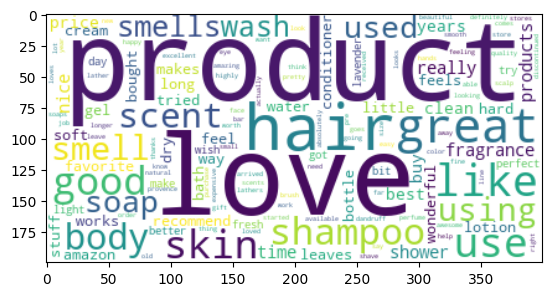

results using <class 'sklearn.feature_extraction.text.TfidfVectorizer'>


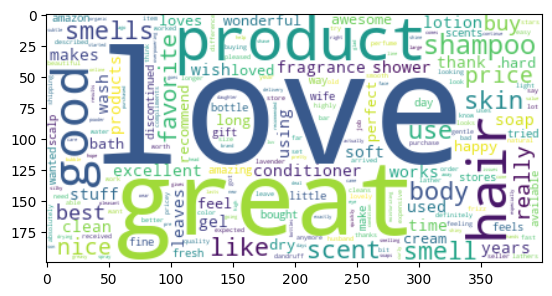

In [67]:
# now we turn the processed words into vectors 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# I am against CountVectorizer because its the most naive way to handle text and semantics. Its like bag of words and one hot encoding - which is usually not preferred 
# TFIDF is slightly better because it gives weights to each word given a corpus.
# For our project, we are likely to be using at least 3 different kinds to evaluate their results.
# Ideally, we will probably use pretrained bert-tokenizers. For this demostration, i will use both tfidf and count of words - you should see their differences 

fig, ax = plt.subplots()

for i in [CountVectorizer,TfidfVectorizer]:
    vectorizer = i(analyzer='word',stop_words= 'english')
    results = vectorizer.fit_transform(X)

    feature_names = vectorizer.get_feature_names_out()
    dense = results.todense()
    lst1 = dense.tolist()

    _sum = np.asarray(results.sum(axis=0)).flatten()
    _dict = dict(zip(feature_names, _sum))
    
    print(f"results using {i}") 
    # Analyze the results with word cloud
    w = (WordCloud(background_color="white", max_words=250).generate_from_frequencies(_dict))
    
    # Show the plot for the current iteration
    
    plt.imshow(w, interpolation='bilinear')
    plt.show()

### Model Training 

Let us use a easier model to demostrate this problem 

In [77]:
# 5 classes - classification problem 
df.overall.unique()

array([5., 1., 2., 4., 3.])

In [87]:
# class imbalance - we should expect a lot of predictions for 5 
# We can address this in our preprocessing steps above - but for now we still stick with this dataset 
df.overall.value_counts()

overall
5.0    4649
4.0     332
1.0     115
3.0     109
2.0      64
Name: count, dtype: int64

In [79]:
# model training 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(results, Y, test_size=0.33, random_state=42)
clf = MLPClassifier(random_state=1, 
                    max_iter=300,
                    activation='relu',
                    hidden_layer_sizes=(30,5),
                    ).fit(X_train, y_train)

C:\Users\Stevie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [85]:
# Prediction 
clf.predict(X_test[:30, :])

array([5., 5., 5., 5., 5., 1., 5., 5., 5., 1., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

In [82]:
# simple results 
clf.score(X_test, y_test)

0.9579976985040276